In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import linear_model
%matplotlib inline

### A. Logistic Regression

#### 1. Data Cleaning

In [2]:
# Open file and inspect first five rows.
df = pd.read_csv('titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Check data types.
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [4]:
# Check if the Survived column, which will be used as the target variable, is binary.
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [5]:
# Check for nulls.
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
# Total rows and columns.
df.shape

(891, 12)

In [7]:
# Drop unnecessary variables.
df_sub = df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)

# Show average age per class and sex.
df_sub.groupby(['Pclass', 'Sex'])['Age'].mean()

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

In [8]:
# Create function to derive age.
def average_age(col):
    Age = col[0]
    Pclass = col[1]
    Sex = col[2]
    if pd.isnull(Age):
        if (Pclass == 1) & (Sex=='female'):
            return 35
        elif (Pclass == 1) & (Sex=='male'):
            return 41
        elif (Pclass == 2) & (Sex=='female'):
            return 29
        elif (Pclass == 2) & (Sex=='male'):
            return 31
        elif (Pclass == 3) & (Sex=='female'):
            return 22
        else:
            return 27
    else:
        return Age
    
# Impute null values in the age column based on the passenger class and sex averages.
df_sub['Age'] = df_sub[['Age', 'Pclass','Sex']].apply(average_age, axis=1)

# Drop remaining nulls.
df_sub.dropna(inplace=True)

# Convert categorical variables.
df_sub = pd.get_dummies(df_sub)

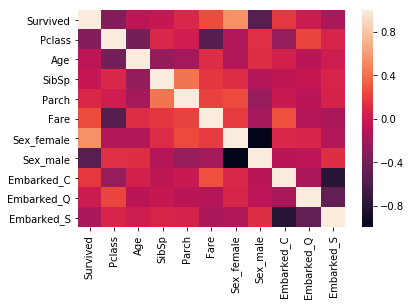

In [9]:
# Check correlated variables.
sns.heatmap(df_sub.corr())  

In [10]:
# Drop redundant variables.
df_sub = df_sub.drop(['Sex_female', 'Fare','Embarked_S'], axis=1)

In [11]:
df_sub.head()

,Survived,Pclass,Age,SibSp,Parch,Sex_male,Embarked_C,Embarked_Q
0,0,3,22.0,1,0,1,0,0
1,1,1,38.0,1,0,0,1,0
2,1,3,26.0,0,0,0,0,0
3,1,1,35.0,1,0,0,0,0
4,0,3,35.0,0,0,1,0,0


#### 2. Train/Test/Split

In [12]:
# Set variables.
y = df_sub['Survived']
X =  df_sub.drop(['Survived'], axis=1)

# Split train and test data.
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

# Fit the model.
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
logr_fit = logr.fit(X_train, y_train)

# Make predictions.
logr_pred = logr.predict(X_test)

# Accuracy score.
from sklearn.metrics import accuracy_score
print('Score:', accuracy_score(y_test, logr_pred))

Score: 0.775280898876


C:\Users\James\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
# Confusion matrix.
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, logr_pred)
print(confusion_matrix)

[[138  26]
 [ 34  69]]


In [14]:
# Classification matrix.
from sklearn.metrics import classification_report
print(classification_report(y_test, logr_pred))

             precision    recall  f1-score   support

          0       0.80      0.84      0.82       164
          1       0.73      0.67      0.70       103

avg / total       0.77      0.78      0.77       267



#### 3. Cross Validation

In [15]:
from sklearn.model_selection import cross_val_score
print('Average Score: ', cross_val_score(logr, X, y, cv=10).mean())

Average Score:  0.805388151175


### B. Ridge Regression

In [16]:
# Create function to determine optimum lambda.
def optimum_lambda(model, a, b, c):
    
    # Set parameters.
    scores = {}
    keys = np.arange(a, b, c)
    for lambd in keys:
        if model == 'ridge':
            reg_model = linear_model.Ridge(alpha=lambd)
        elif model == 'lasso':
            reg_model = linear_model.Lasso(alpha=lambd)
        else:
            print('Model error')
    
        # Fit and predict.
        reg_model.fit(X_train, y_train)
        score = reg_model.score(X_test, y_test)
        scores[lambd] = score
    
    # Train/test split score at optimum lambda.
    max_value = max(scores.values())
    max_key = [k for k, v in scores.items() if v == max_value]
    print('Optimum lambda and corresponding train/test split score:')
    print(max_key, max_value)

    # Cross validation score at optimum lambda.
    if model == 'ridge':
        model_max = linear_model.Ridge(alpha=max_key)
    elif model == 'lasso':
        model_max = linear_model.Lasso(alpha=max_key)
    print('Cross validation average score at optimum lambda: ', cross_val_score(model_max, X, y, cv=10).mean())

In [17]:
# Determine ridge regression scores.
optimum_lambda('ridge', 0, 100, 0.1)

Optimum lambda and corresponding train/test split score:
[13.800000000000001] 0.330656984976
Cross validation average score at optimum lambda:  0.365432632078


### C. Lasso Regression

In [18]:
# Determine lasso regression scores.
import warnings
warnings.filterwarnings('ignore')
optimum_lambda('lasso', 0, 10, 0.01)

Optimum lambda and corresponding train/test split score:
[0.0] 0.328599549692
Cross validation average score at optimum lambda:  0.365847337423


Logistic regression is the clear winner among the three simply because this problem was a classification one, as such, ridge and lasso are not the best methods to use. In terms of practical considerations, between ridge and lasso, ridge is a bit easier to implement and faster to compute, which may matter depending on the type of data available. Consequently, if there are many small/medium sized effects, ridge will be better suited. If there are only a few variables with a medium/large effect, lasso should be considered.